In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import boto3
from io import StringIO
import time

from matplotlib import rcParams



In [2]:



##############################
#----Function definitions----#
##############################

def run_athena_query(boto_client, query_string, database, output_location):
    '''Run Athena query and output the result

    param boto_client (Boto3 client): Boto3 Athena client
    param query_string (str): SQL query
    param database (str): Athena database name from where tables originate
    param output_location (str): S3 location where queries are stored

    return query_output: Athena output
    '''

    queryStart = boto_client.start_query_execution(
        QueryString = query_string,
        QueryExecutionContext = {
            'Database': database
        },
        ResultConfiguration = {
            'OutputLocation': output_location
        }
    )

    # regularly check to see if query has completed before trying to get output
    status = 'QUEUED' 
    while status in ['RUNNING', 'QUEUED']:
        time.sleep(5)
        status = boto_client.get_query_execution(QueryExecutionId = queryStart['QueryExecutionId'])['QueryExecution']['Status']['State']

    results_paginator = boto_client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(QueryExecutionId = queryStart['QueryExecutionId'])

    results = []
    data_list = []
    for results_page in results_iter:
        for row in results_page['ResultSet']['Rows']:
            data_list.append(row['Data'])
    for datum in data_list[0:]:
        results.append([x['VarCharValue'] if 'VarCharValue' in x else '' for x in datum])
    return [tuple(x) for x in results]

def df2csv_S3(boto_client, df, bucket, key):
    '''Run Athena query and output the result, first emptying the file location

    param boto_client (Boto3 client): Boto3 Athena client
    param df (Pandas dataframe): Dataframe to save
    param bucket (str): Name of S3 bucket file will be saved in
    param key (str): File path
    '''

    boto_client.delete_object(Bucket=bucket, Key=key)

    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, key).put(Body=csv_buffer.getvalue())

##############################################
#----Assume role to gain temp credentials----#
##############################################

# create an STS client object that represents a live connection to the 
# STS service
sts_client = boto3.client('sts')

# Call the assume_role method of the STSConnection object and pass the role
# ARN and a role session name.
assumed_role_object=sts_client.assume_role(
    RoleArn="arn:aws:iam::373598043715:role/Boto3-Access-Assumed",
    RoleSessionName="AssumeRoleSession1"
)

# From the response that contains the assumed role, get the temporary 
# credentials that can be used to make subsequent API calls
credentials=assumed_role_object['Credentials']

# Use the temporary credentials that AssumeRole returns to make a 
# connection to Amazon S3  
s3_resource=boto3.resource(
    's3',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken'],
)


In [3]:
athena_client = boto3.client(
    'athena',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

database = 'cq_user_activity'
output_location = 's3://playfab-events-processing/athena-query-results/boto-temp-outputs'

query = '''
    SELECT 
        eventid, 
        entitylineage.titleplayeraccountid titleid,
        entitylineage.masterplayeraccountid masterid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."com_playfab_entity_created"
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
users = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT 
        eventid, 
        entitylineage.titleplayeraccountid titleid,
        entitylineage.masterplayeraccountid masterid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."com_playfab_entity_created"
    WHERE entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
allusers = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT
        eventid, 
        entityid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_opens_hamburger_menu" 
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
hamburger = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT
        eventid,
        entityid,
        questprovidername,
        questproviderid,
        questtitle,
        questid,
        questtype,
        questdate,
        queststarttime,
        questendtime,
        questlocationname, 
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_taps_commit_to_bail_button" 
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
bails = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT
        eventid,
        entityid,
        questprovidername,
        questproviderid,
        questtitle,
        questid,
        questtype,
        questdate,
        queststarttime,
        questendtime,
        questlocationname, 
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_taps_commit_to_volunteer_button"  
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
volunteers = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT
        eventid,
        entityid,
        questprovidername,
        questproviderid,
        questtitle,
        questid,
        questtype,
        questdate,
        queststarttime,
        questendtime,
        questlocationname, 
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_taps_outside_app_volunteer_link"
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
links = pd.DataFrame(response[1:], columns=response[0])


query = '''
    SELECT
        eventid, 
        entityid,
        clusterlocationname,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_views_cluster"
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
clusters = pd.DataFrame(response[1:], columns=response[0])


query = '''
    SELECT
        eventid, 
        entityid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_views_legacy_feature" 
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
legacies = pd.DataFrame(response[1:], columns=response[0])


query = '''
    SELECT
        eventid, 
        entityid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_views_their_earned_legacies"
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
achievements = pd.DataFrame(response[1:], columns=response[0])

query = '''
    SELECT
        eventid,
        entityid,
        questprovidername,
        questproviderid,
        questtitle,
        questid,
        questtype,
        questdate,
        queststarttime,
        questendtime,
        questlocationname, 
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_views_quest"
    WHERE timestamp >= '2021-01-15 05:00:00' AND
        entityid NOT IN ('BFF17905F1991B38', 'C44F33E8E131F4ED')
'''

response = run_athena_query(athena_client, query, database, output_location)
quests = pd.DataFrame(response[1:], columns=response[0])


In [5]:
yquests = quests['entityid'].unique().tolist()
yhamburger = hamburger['entityid'].unique().tolist()
ybails = bails['entityid'].unique().tolist()
yvolunteers = volunteers['entityid'].unique().tolist()
ylinks = links['entityid'].unique().tolist()
yclusters = clusters['entityid'].unique().tolist()
ylegacies = legacies['entityid'].unique().tolist()
yachievements = achievements['entityid'].unique().tolist()

df = users.copy()
df['quest'] = np.where(df['masterid'].isin(yquests), True, False)
df['hamburger'] = np.where(df['masterid'].isin(yhamburger), True, False)
df['bail'] = np.where(df['masterid'].isin(ybails), True, False)
df['volunteer'] = np.where(df['masterid'].isin(yvolunteers), True, False)
df['link'] = np.where(df['masterid'].isin(ylinks), True, False)
df['cluster'] = np.where(df['masterid'].isin(yclusters), True, False)
df['legacymenu'] = np.where(df['masterid'].isin(ylegacies), True, False)
df['achievements'] = np.where(df['masterid'].isin(yachievements), True, False)


Text(0.5, 0, 'Activity')

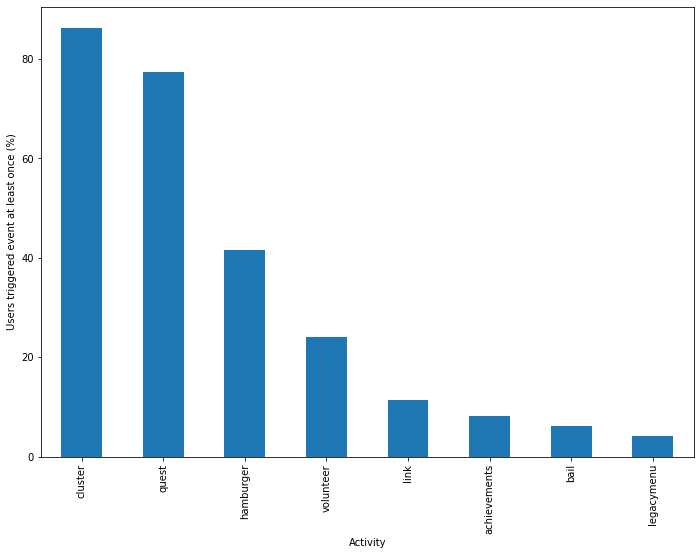

In [6]:
variety = df[['quest','hamburger','bail','volunteer','link','cluster','legacymenu','achievements']].sum().sort_values(ascending=False)
variety = variety/len(users) * 100

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

ax = variety.plot.bar()
ax.set_ylabel('Users triggered event at least once (%)')
ax.set_xlabel('Activity')

<AxesSubplot:xlabel='life', ylabel='nquestid'>

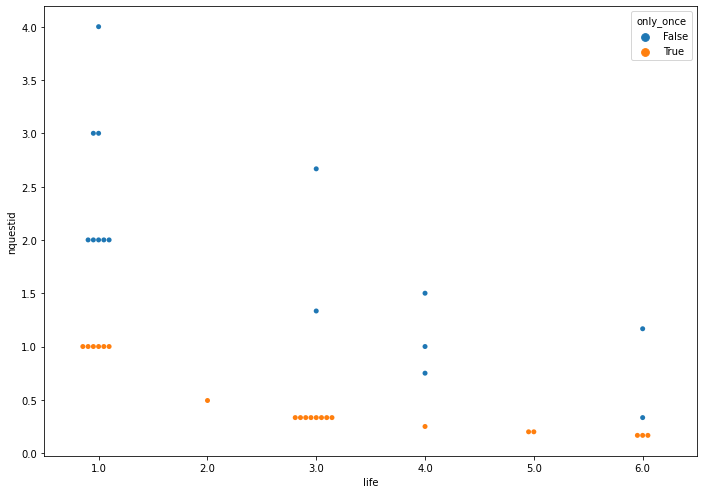

In [8]:
aufreq = users.copy()
aufreq['timestamp'] = pd.to_datetime(aufreq['timestamp'])

aufreq['life'] = pd.to_datetime('2021-03-03 00:00:00.000') - pd.to_datetime(aufreq['timestamp'])
aufreq['life'] = aufreq['life'].apply(lambda x: np.floor(x/np.timedelta64(1,'W')))

conf_vol = volunteers.groupby(['entityid']).agg('nunique').reset_index()

aufreq = aufreq[['masterid', 'life']].merge(conf_vol, left_on='masterid', right_on='entityid')

aufreq = aufreq[aufreq['life']>0]

aufreq['nquestid'] = aufreq['questid'] / aufreq['life']
# aufreq['onlyonce'] = (aufreq['nquestid'] * aufreq(['life']) /  > 1 #weekly regular
aufreq['only_once'] = aufreq['nquestid'] * aufreq['life'] <= 1

sns.swarmplot(x='life', y='nquestid', hue='only_once', data=aufreq)

<AxesSubplot:xlabel='life', ylabel='nquestid'>

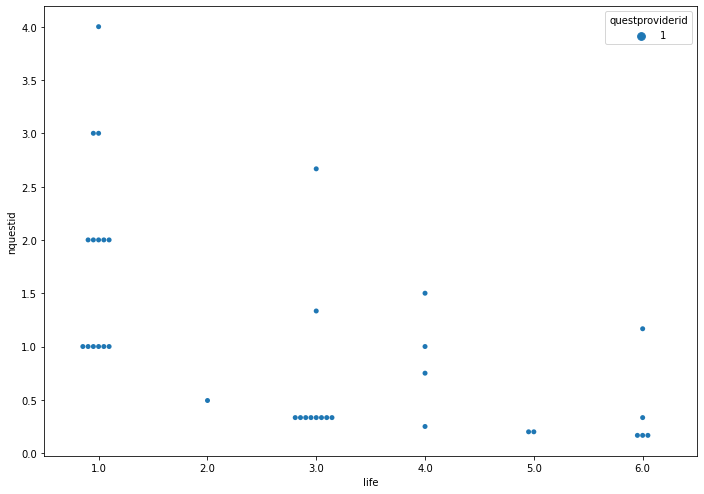

In [18]:
sns.swarmplot(x='life', y='nquestid', hue='questproviderid', data=aufreq)


<AxesSubplot:xlabel='life', ylabel='nquestid'>

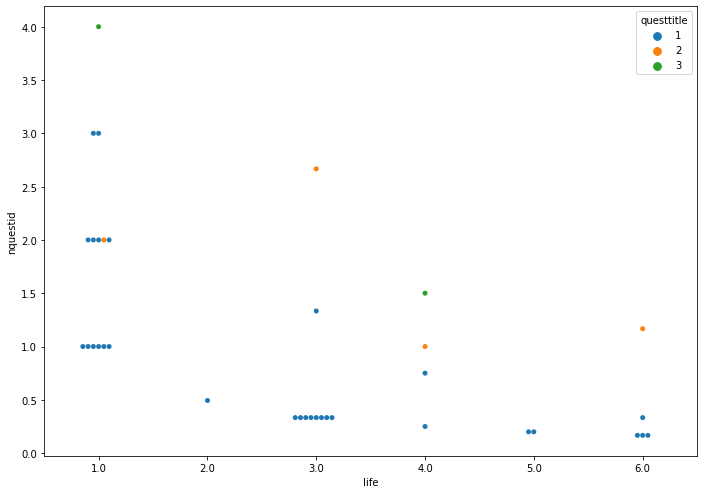

In [19]:
sns.swarmplot(x='life', y='nquestid', hue='questtitle', data=aufreq)


In [59]:
clusters['clusterlocationname'].value_counts()

Hoboken Food Pantry          928
The Hoboken Shelter          809
Multi-Service Center         328
Jubilee Center               263
Computers 4 People           172
The Laboratory                26
Hoboken Housing Authority      7
Choc O Pain                    2
Round 2 Resources              1
Name: clusterlocationname, dtype: int64

<AxesSubplot:xlabel='clusterlocationname', ylabel='count'>

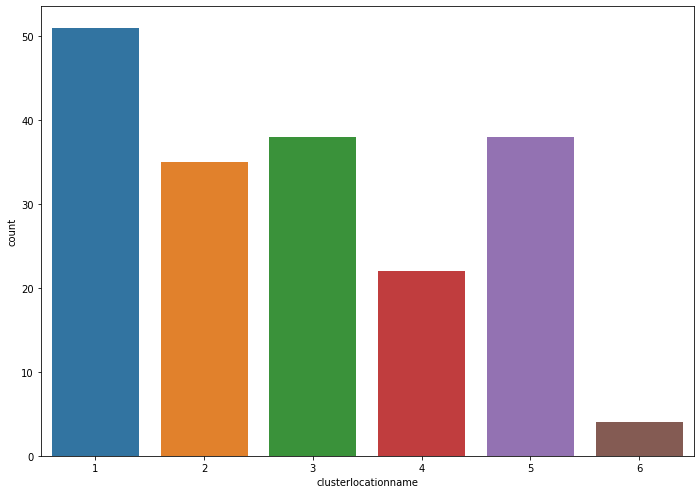

In [26]:
churned_clust = clusters[~clusters['entityid'].isin(yvolunteers)].groupby(['entityid']).agg('nunique').reset_index()

sns.countplot(x='clusterlocationname', data=churned_clust)

<AxesSubplot:xlabel='clusterlocationname', ylabel='count'>

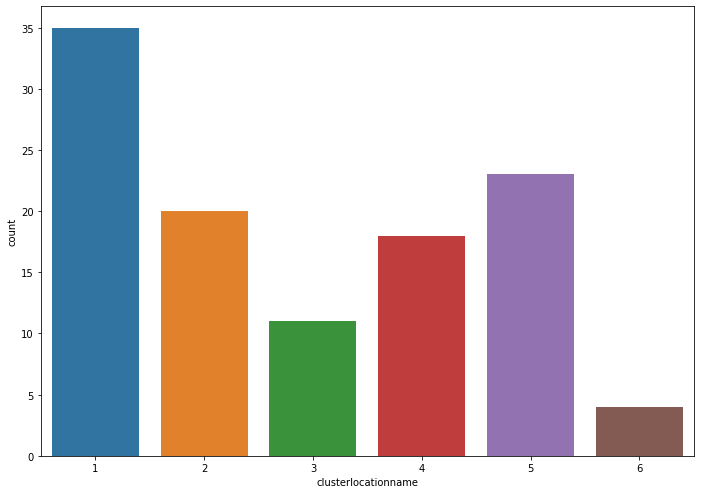

In [27]:

active_clust = clusters[clusters['entityid'].isin(yvolunteers)].groupby(['entityid']).agg('nunique').reset_index()
sns.countplot(x='clusterlocationname', data=active_clust)

In [25]:
clusters[clusters['entityid'].isin(volunteers)]

,eventid,entityid,clusterlocationname,timestamp


In [52]:
volunteers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   eventid            374 non-null    object
 1   entityid           374 non-null    object
 2   questprovidername  374 non-null    object
 3   questproviderid    374 non-null    object
 4   questtitle         374 non-null    object
 5   questid            374 non-null    object
 6   questtype          374 non-null    object
 7   questdate          374 non-null    object
 8   queststarttime     374 non-null    object
 9   questendtime       374 non-null    object
 10  questlocationname  374 non-null    object
 11  timestamp          374 non-null    object
dtypes: object(12)
memory usage: 35.2+ KB


In [54]:
volunteers['questprovidername'].value_counts()

The Hoboken Food Pantry        192
The Hoboken Shelter            178
Test Provider                    2
The Hoboken Family Alliance      1
Community Lifestyle              1
Name: questprovidername, dtype: int64

In [57]:
volunteers[volunteers['entityid']=='3C540E120FF27EEB'].groupby('entityid').agg('nunique')

,eventid,questprovidername,questproviderid,questtitle,questid,questtype,questdate,queststarttime,questendtime,questlocationname,timestamp
entityid,,,,,,,,,,,
3C540E120FF27EEB,6,1,1,3,6,1,6,2,2,1,6


In [59]:
volunteers[volunteers['entityid']=='3C540E120FF27EEB']

,eventid,entityid,questprovidername,questproviderid,questtitle,questid,questtype,questdate,queststarttime,questendtime,questlocationname,timestamp
117,d34d2f0701c3482287cb504e70af109d,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Organize The Pantry,257,special,3/9/2021,10:00 AM,12:00 PM,Hoboken Food Pantry,2021-02-23 21:05:04.004
125,1d5e093c36d142c6b9cc0cbae738be6d,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Organize The Pantry,272,special,3/23/2021,10:00 AM,12:00 PM,Hoboken Food Pantry,2021-02-23 21:06:10.619
139,3a9c51ff83714f92b4071e9c524d2c5e,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Take Inventory,241,special,2/23/2021,10:00 AM,12:00 PM,Hoboken Food Pantry,2021-02-04 22:55:24.311
228,59b330c03c594bd8b557b29ee92c1859,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Family Hours,267,special,3/16/2021,8:45 AM,11:00 AM,Hoboken Food Pantry,2021-02-23 21:07:52.774
281,3e75b8c541d44ef2b8b0f31d0a2c66fe,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Family Hours,282,special,3/30/2021,8:45 AM,11:00 AM,Hoboken Food Pantry,2021-02-23 21:07:16.608
301,a7988202e2954ff0aee957c82fc0e8e0,3C540E120FF27EEB,The Hoboken Food Pantry,847F21FAD0FFC647,Take Inventory,225,special,2/9/2021,10:00 AM,12:00 PM,Hoboken Food Pantry,2021-02-01 01:04:47.710


In [ ]:
athena_client = boto3.client(
    'athena',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

database = 'playfab_events'
output_location = 's3://playfab-events-processing/athena-query-results/boto-temp-outputs'


query = '''
    WITH users AS (
    SELECT 
        entitylineage.titleplayeraccountid titleid,
        entitylineage.masterplayeraccountid masterid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."com_playfab_entity_created"
    WHERE timestamp >= '2021-01-15 00:00:00'),

    hamburger AS (
    SELECT 
        entityid,
        CAST(FROM_ISO8601_TIMESTAMP("Timestamp") AS TIMESTAMP) timestamp
    FROM "cq_user_activity"."title_feaac_chariteer_opens_hamburger_menu"
    WHERE timestamp >= '2021-01-15 00:00:00')

    SELECT users.masterid
    FROM users
    JOIN hamburger ON users.masterid = hamburger.entityid 
'''


response = run_athena_query(athena_client, query, database, output_location)
df = pd.DataFrame(response[1:], columns=response[0])



In [ ]:
df